# Partitioning SPP

This notebook follows up on `Comparing maps`, and describes how to partition the NERC SPP region.

## Setup

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display
import geopandas as gp
import pandas as pd
import geoplot
import numpy as np
from sklearn import neighbors

Start by reading in the chosen input data source, and correcting some labels to a common nomenclature.

In [3]:
ecoinvent = gp.read_file("data/ecoinvent/electricity.gpkg")

mapping = {
    "US-ASCC": "ASCC",
    "US-FRCC": "FRCC",
    "US-HICC": "HICC",
    "MRO": "MRO",
    "NPCC": "NPCC",
    "US-RFC": "RFC",
    "US-SERC": "SERC",
    "US-SPP": "SPP",
    "US-TRE": "TRE",
    "WECC": "WECC",
}

# Only need SPP region
ecoinvent = ecoinvent[ecoinvent['shortname'] == "US-SPP"]
# Use `mapping` to normalize names
ecoinvent['NERC'] = ecoinvent['shortname'].transform(lambda s: mapping[s])
# Drop all other unnecessary columns
ecoinvent = ecoinvent[['NERC', 'geometry']]

Load 2018 eGrid data

In [ ]:
egrid_csv = pd.read_csv("data/egrid/egrid2018_data_v2.csv", skiprows=[1])

Filter some of the eGrid data to remove invalid or unusable rows.

In [5]:
# Only use values which have GIS coordinates
egrid_csv = egrid_csv[egrid_csv['Plant latitude'] < 90]

# SPP no longer exists
print("Removing {} plants labeled SPP".format(sum(egrid_csv['NERC region acronym'] == 'SPP')))
egrid_csv = egrid_csv[egrid_csv['NERC region acronym'] != 'SPP']

Removing 2 plants labeled SPP


In [6]:
egrid = gp.GeoDataFrame(
    egrid_csv, 
    geometry=gp.points_from_xy(egrid_csv['Plant longitude'], egrid_csv['Plant latitude']),
    crs = {'init' :'epsg:4326'}
).rename(columns={'NERC region acronym': 'NERC'})

Make sure they coordinate reference systems are defined the same way.

In [7]:
ecoinvent.crs = egrid.crs

We want to use not just the eGrid plants in the SPP, but also ones close by - this will make our results more sensible.

In [8]:
ecoinvent_buffered = ecoinvent.copy()
ecoinvent_buffered['geometry'] = ecoinvent_buffered.geometry.buffer(1)

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Create two new geodataframes with eGrid plants within SPP and the buffered SPP

In [9]:
egrid_buffered = gp.sjoin(egrid, ecoinvent_buffered, how='inner', op='intersects', lsuffix='egrid', rsuffix='ecoinvent')

In [10]:
egrid = gp.sjoin(egrid, ecoinvent, how='inner', op='intersects', lsuffix='egrid', rsuffix='ecoinvent')

In [11]:
len(egrid), len(egrid_buffered)

(523, 945)

A helper function to make graphing easier

In [12]:
def set_bounds_by_layer(lyr, ax):
    xlim = ([lyr.total_bounds[0],  lyr.total_bounds[2]])
    ylim = ([lyr.total_bounds[1],  lyr.total_bounds[3]])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)    

# Selecting a method to partition SPP

The initial idea is to use [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram). Let's see what the actual data looks like:

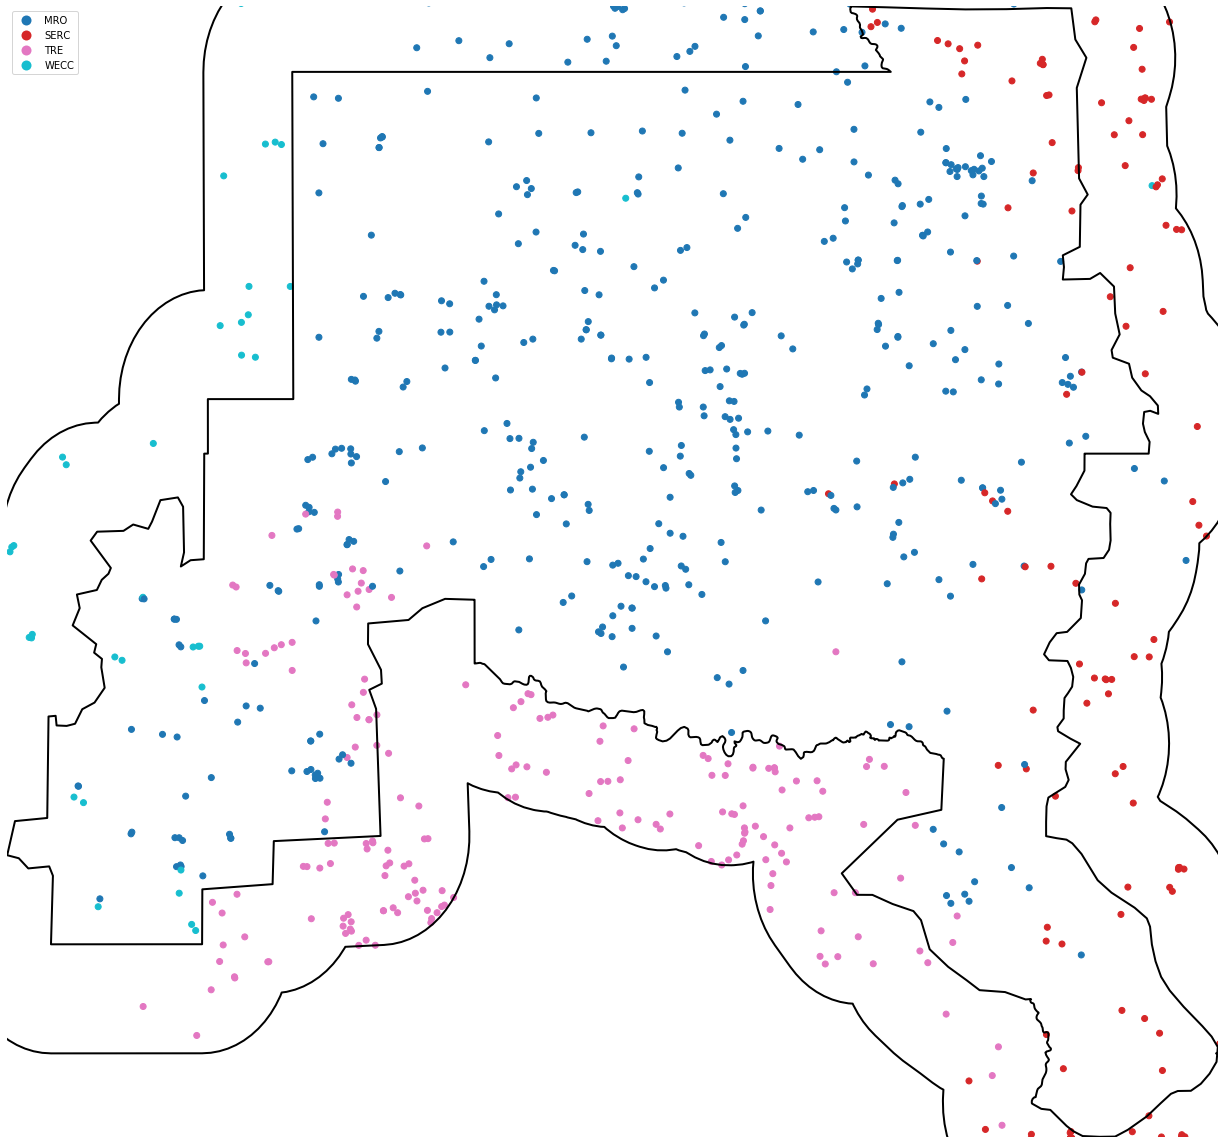

In [15]:
fig, ax = plt.subplots(figsize = (20,16)) 
egrid_buffered.plot(column='NERC_egrid', categorical=True, ax=ax, legend=True)
ecoinvent_buffered.boundary.plot(edgecolor='k', linewidth = 2, ax=ax) 
ecoinvent.boundary.plot(edgecolor='k', linewidth = 2, ax=ax) 


ax.axis('off')
set_bounds_by_layer(ecoinvent, ax)
plt.tight_layout()

The mixing of plants in the same area is a big problem. The Voronoi algorithm will create strange shapes and many "islands", and so won't produce meaningful results.

Another approach is K nearest neighbors from [scikit-learn](https://scikit-learn.org/stable/modules/neighbors.html). This approach allows for a more probabilistic result, and should produce smoother edges. We know that we want the version with distance-based weights, but need to try different values for two tuning parameters:

* The number of neighbors
* The resolution of the result grid

However, we need to start by transforming the input data from GIS objects and strings to Numpy arrays.

In [17]:
nerc_mapping = dict(zip(sorted(egrid_buffered.NERC_egrid.unique()), range(10)))
nerc_mapping

{'MRO': 0, 'SERC': 1, 'TRE': 2, 'WECC': 3}

In [18]:
training = np.hstack([
    egrid_buffered['Plant longitude'].to_numpy().reshape([-1, 1]),
    egrid_buffered['Plant latitude'].to_numpy().reshape([-1, 1])
])
target = egrid_buffered.NERC_egrid.transform(lambda x: nerc_mapping[x]).to_numpy()

In [21]:
def parameterized_fit(N=500, n_neighbors=6):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(training, target)
    
    bounds = ecoinvent.geometry.bounds

    xs, ys = np.meshgrid(
        np.linspace(bounds.minx.min(), bounds.maxx.max(), N),
        np.linspace(bounds.miny.min(), bounds.maxy.max(), N),    
    )
    
    result = clf.predict(np.c_[xs.ravel(), ys.ravel()])
    return xs, ys, result.reshape(xs.shape)

We can now look at maps with various input values. We don't have an objective criteria to select a map - instead, we are looking for smooth edges, few islands, and overall reasonableness. The NERC regions overlap, so there is no "ground truth" - we acknolwedge and embrace that this is a subjective process.

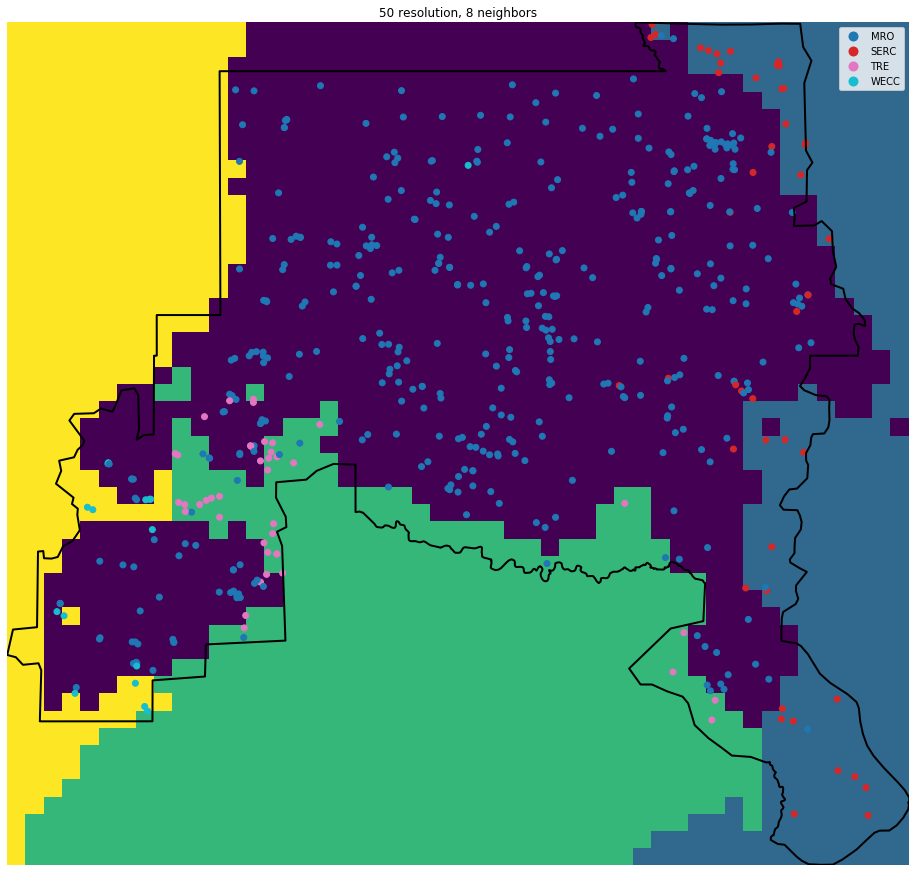

<Figure size 432x288 with 0 Axes>

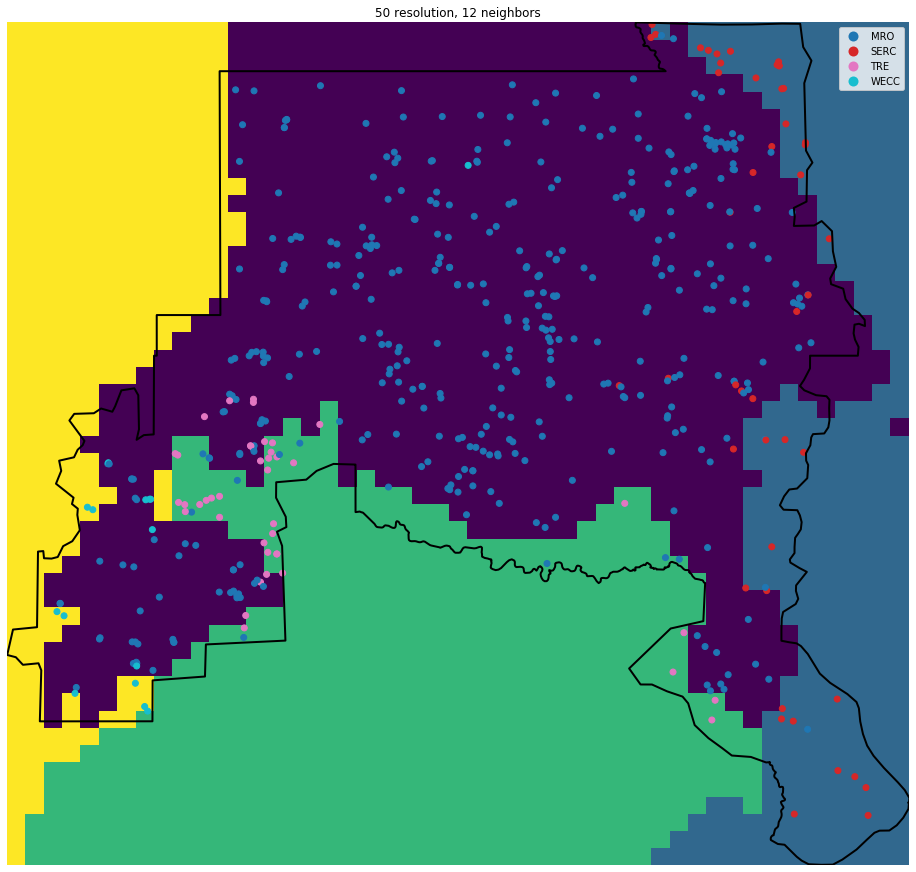

<Figure size 432x288 with 0 Axes>

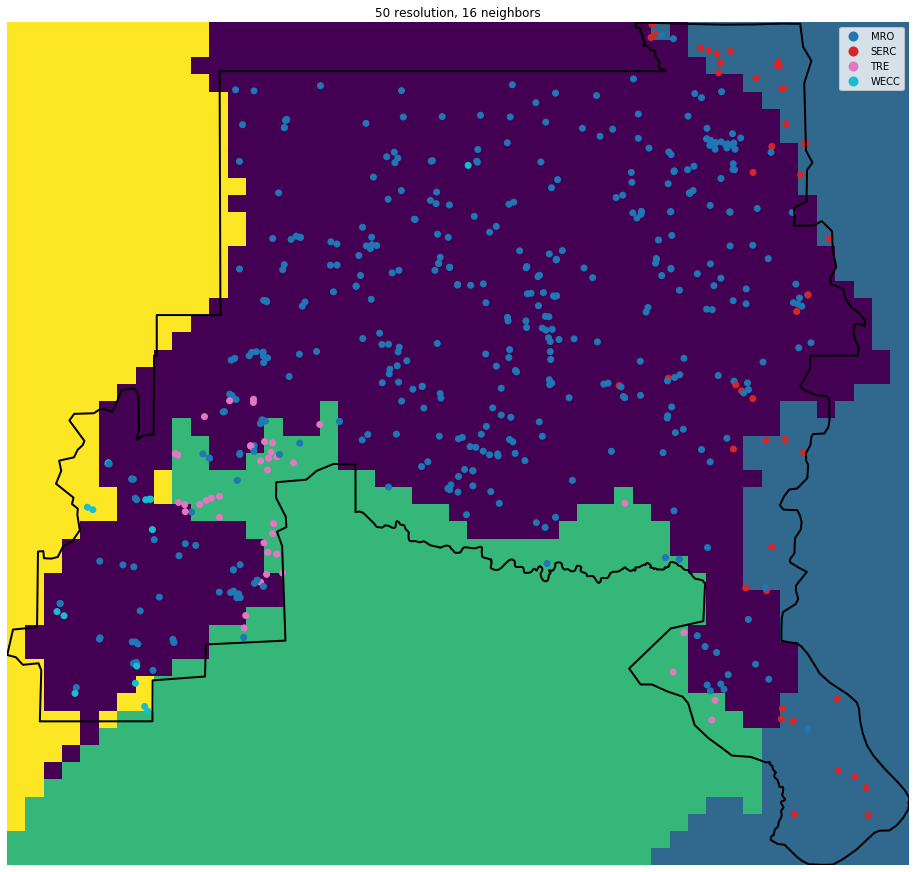

<Figure size 432x288 with 0 Axes>

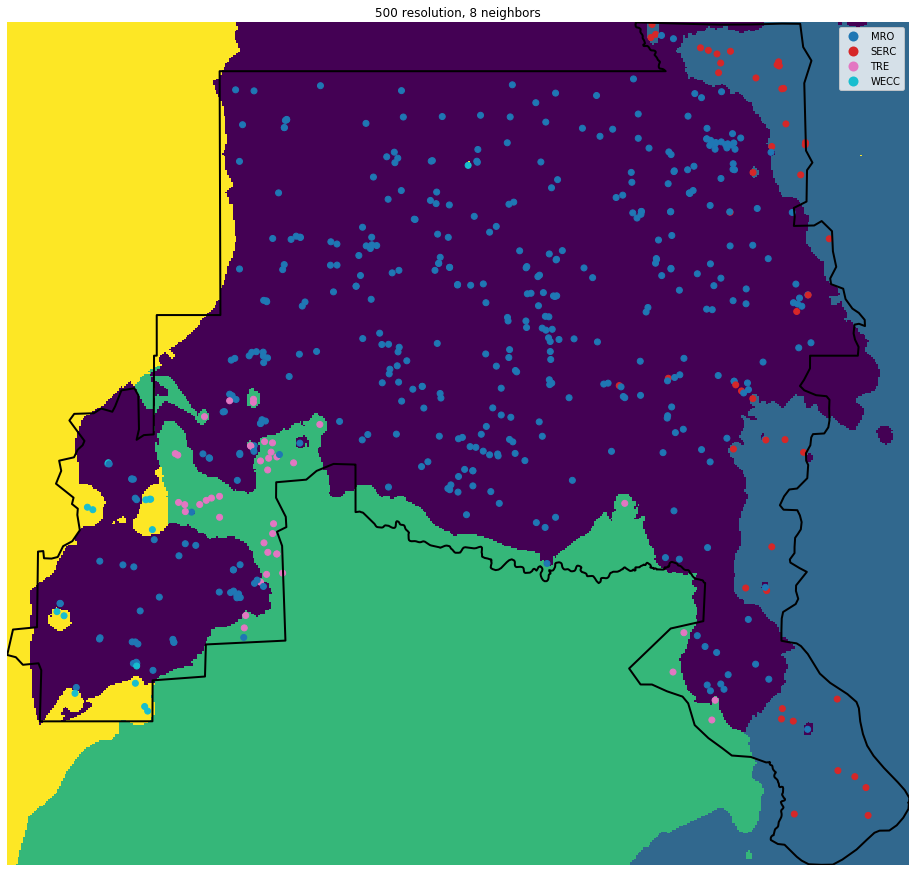

<Figure size 432x288 with 0 Axes>

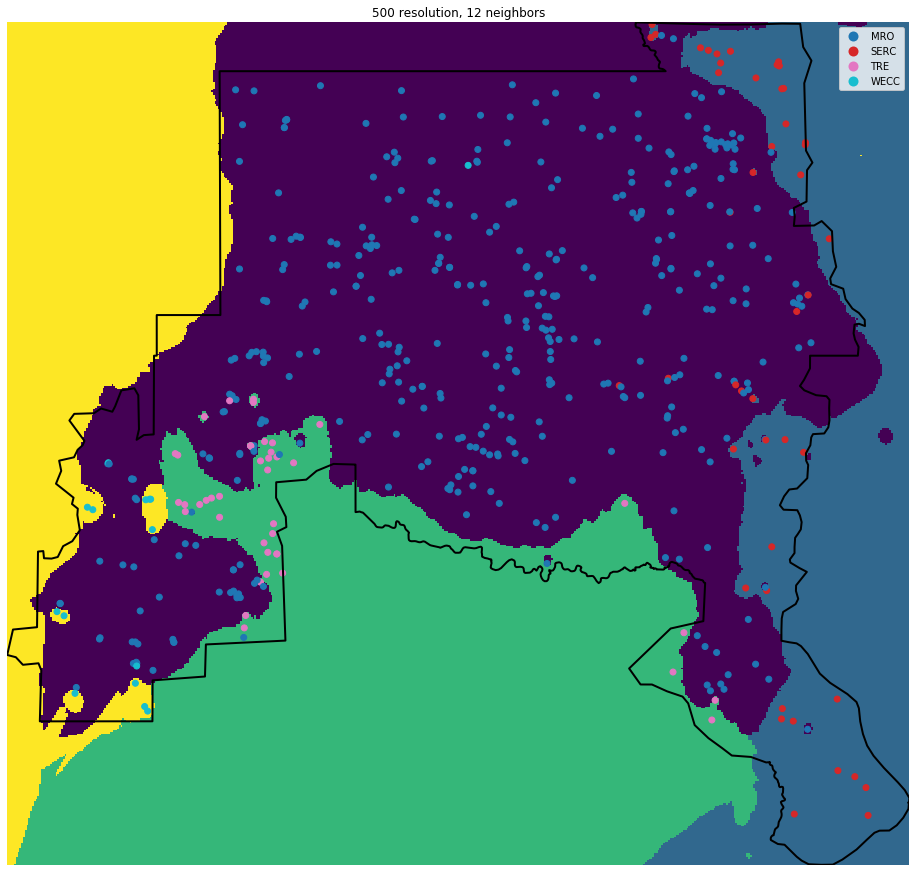

<Figure size 432x288 with 0 Axes>

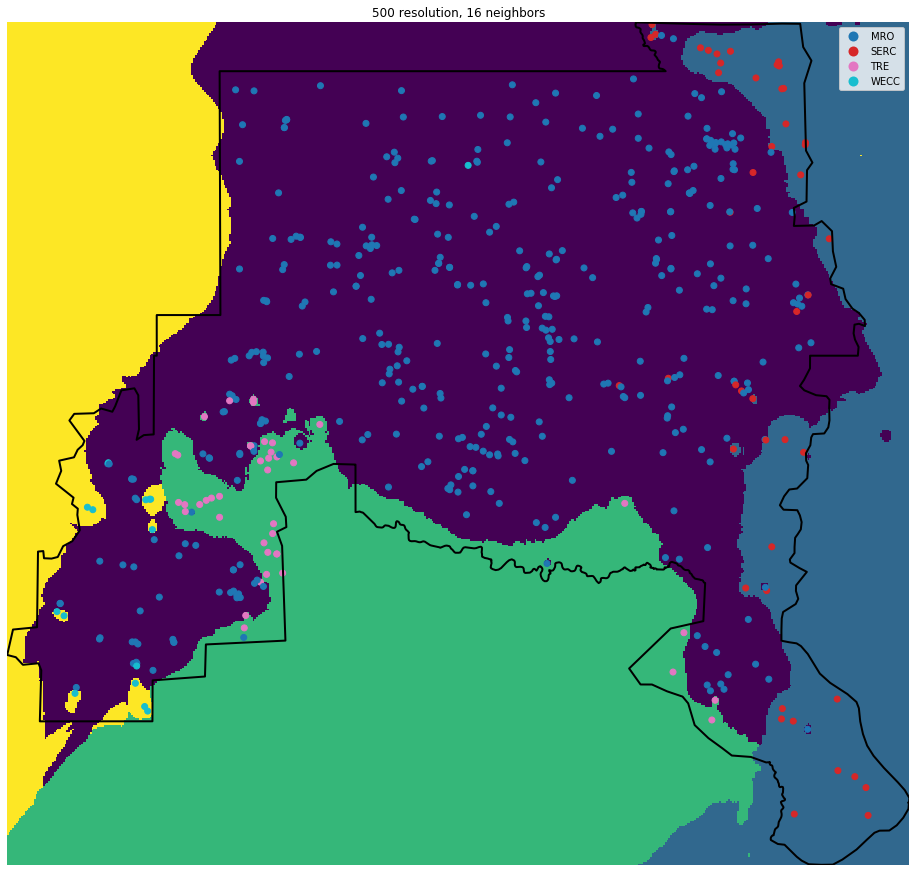

<Figure size 432x288 with 0 Axes>

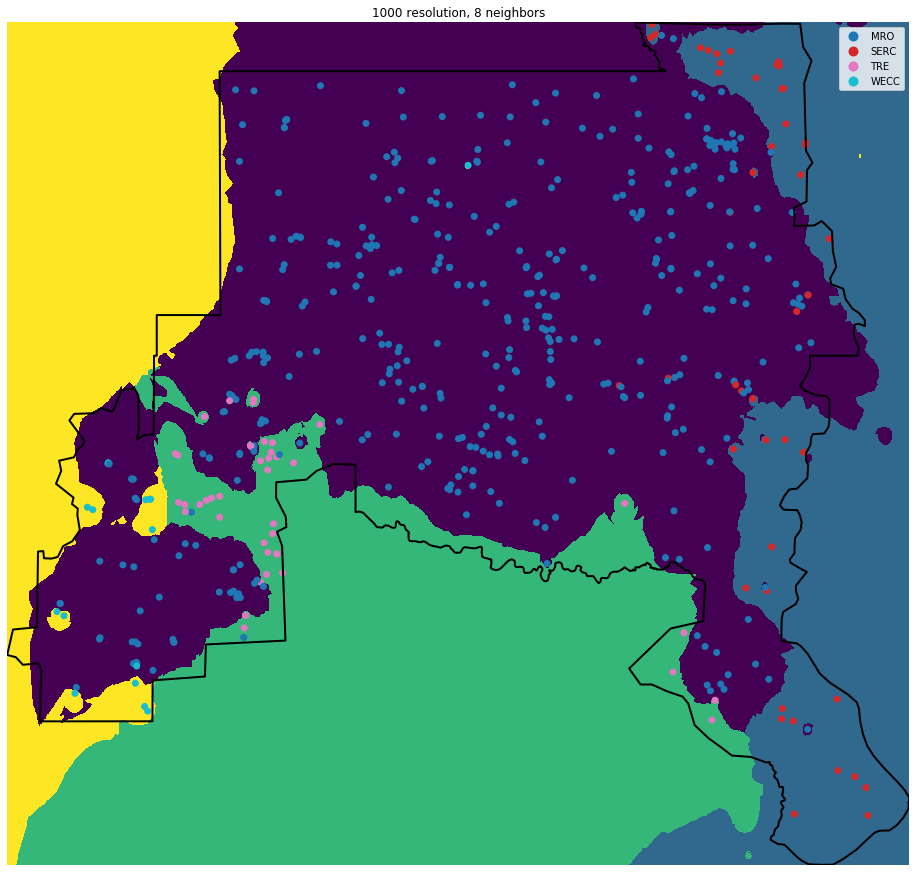

<Figure size 432x288 with 0 Axes>

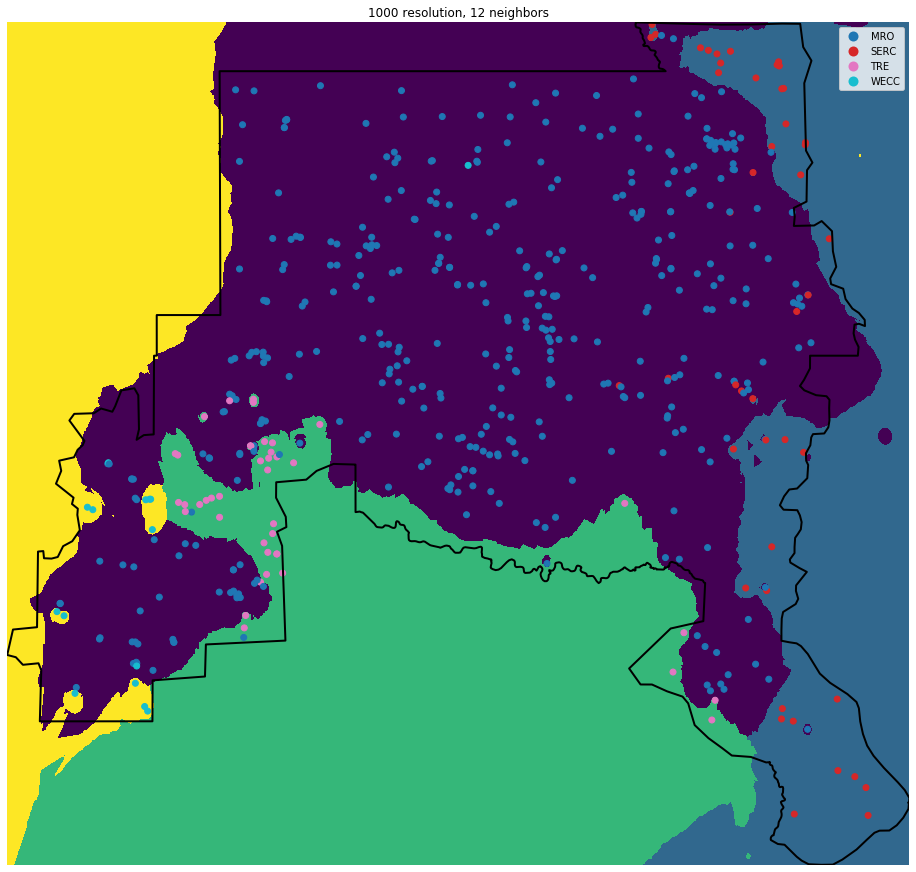

<Figure size 432x288 with 0 Axes>

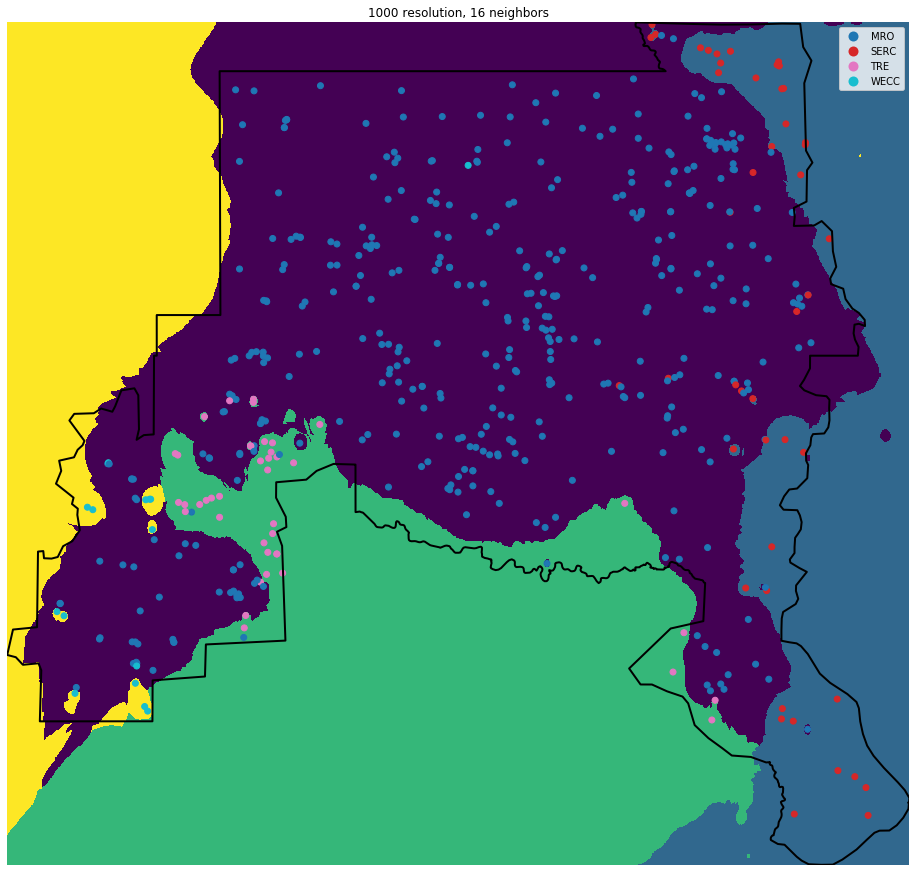

<Figure size 432x288 with 0 Axes>

In [24]:
for n in (50, 500, 1000):
    for nn in (8, 12, 16):

        fig, ax = plt.subplots(figsize = (16, 12)) 

        ax.pcolormesh(*parameterized_fit(n, nn))

        egrid.plot(column='NERC_egrid', categorical=True, ax=ax, legend=True)
        ecoinvent.boundary.plot(edgecolor='k', linewidth = 2, ax=ax) 

        ax.axis('off')
        set_bounds_by_layer(ecoinvent, ax)
        plt.tight_layout()
        plt.title(f"{n} resolution, {nn} neighbors")
        plt.show()
        plt.clf()

In my opinion, the map with a resolution of 1000 x 1000, and consideration of the 12 nearest neighbors, best fits our purposes. We take this map and turn it back into a GIS file.

In [40]:
latitude, longitude, data = parameterized_fit(1000, 12)

In [41]:
df = pd.DataFrame(
    data=zip(longitude.ravel(), latitude.ravel(), data.ravel()),
    columns=('latitude', 'longitude', 'value_int')
)

rev_mapping = {v: k for k, v in nerc_mapping.items()}
df['nerc'] = df['value_int'].transform(lambda s: rev_mapping[s])

In [42]:
gdf = gp.GeoDataFrame(
    df, 
    geometry=gp.points_from_xy(df.longitude, df.latitude),
    crs = {'init' :'epsg:4326'}
)

This file is large, and is not included in the repo, but is easy to reproduce.

In [43]:
gdf.to_file("data/points.gpkg", driver="GPKG")